# BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [2]:
cptac.download(dataset='renalccrcc')

All files already downloaded and correct.


True

In [3]:
re = cptac.RenalCcrcc()
proteomics = re.get_proteomics()
transcriptomics = re.get_transcriptomics()
clinical = re.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [4]:
clinical['histologic_type'].value_counts()

Clear cell renal cell carcinoma        103
non-Clear Cell renal cell carcinoma      7
Name: histologic_type, dtype: int64

In [5]:
#Data cleaning. We want to get rid of non_clear cell carcinoma, 
#as it throws off our analysis, and isn't what we are studying
non_clear_cell_filter = clinical['histologic_type'] == 'non-Clear Cell renal cell carcinoma'
clinical = clinical[~non_clear_cell_filter]

In [6]:
#We also need to get rid of those samples in the datasets we plan to use. In this case, Proteomics.
rows_to_drop = []

for i, item in enumerate(proteomics.index):
    if item not in list(clinical.index):
        rows_to_drop.append(item)
proteomics.drop(rows_to_drop)

print("Rows Dropped:")
print(rows_to_drop)

Rows Dropped:
['S011', 'S097', 'S104', 'S107', 'S115', 'S119', 'S123']


In [7]:
#Create a copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical.copy())

In [8]:
#Convert columns that should be numeric to numeric
annotations['age'] = annotations['age'].replace('>=90', 90)
annotations['age'] = pd.to_numeric(annotations['age'])

annotations['age_started_smoking'] = annotations['age_started_smoking'].replace('Unknown', np.nan)
annotations['age_started_smoking'] = pd.to_numeric(annotations['age_started_smoking'])

annotations['age_stopped_smoking'] = annotations['age_stopped_smoking'].replace('Unknown', np.nan)
annotations['age_stopped_smoking'] = pd.to_numeric(annotations['age_stopped_smoking'])

annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'] = annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'].replace('Unknown', np.nan)
annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'] = pd.to_numeric(annotations['how_many_cigarettes_usually_smoke_on_the_days_participant_smoked'])

In [9]:
#Drop irrelevant columns
irrelevant_cols = ['Patient_ID', 'height_in_cm', 'weight_in_kg', 'race', 'ethnicity', 
                   'ethnicity_self_identified','tumor_site_other', 'sarcomatoid_features', 
                   'pathologic_findings_in_nonneoplastic_kidney_specify', 
                   'other_immunohistochemistry_specify', 'other_testing_performed', 
                   'other_coagulopathies', 'exposure_to_secondhand_smoke', 
                   'tumor_tissue_collection_clamps_used','tumor_tissue_collection_frozen_with_OCT', 
                   'preoperative_IV_sedation_administered',  'preoperative_IV_opiates_administered', 
                   'preoperative_IV_antiemetics_administered','preoperative_IV_anti_acids_administered', 
                   'other_preoperative_IV_medications_administered', 'platelets',
                   'local_anesthesia_agents_administered', 'regional_anesthesia_agents_administered', 
                   'IV_anesthesia_agents_administered', 'IV_narcotic_opiate_agents_administered', 
                   'IV_muscle_relaxants_administered', 'inhalation_anesthesia_agents_administered', 
                   'additional_anesthesia', 'other_medications_administered_during_surgery', 
                   'surgical_procedure', 'epochs_of_oxygen_desaturation', 'time_specimen_left_OR', 
                   'first_participant_temperature_recorded_in_OR', 'first_temperature_recorded_in_OR_units', 
                   'first_temperature_recorded_in_OR_celsius', 'time_of_first_temperature', 
                   'first_temperature_recorded_in_OR_fahrenheit', 'second_participant_temperature_recorded_in_OR', 
                   'second_temperature_recorded_in_OR_units','second_temperature_recorded_in_OR_celsius', 
                   'second_temperature_recorded_in_OR_fahrenheit', 'time_of_second_temperature', 
                   'Karnofsky_score_at_12months_follow_up', 'Karnofsky_score_at_24months_follow_up', 
                   'performance_status_scale_timing_at_12months_follow_up', 
                   'performance_status_scale_timing_at_24months_follow_up', 
                   'adjuvant_postoperative_radiation_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_radiation_therapy_at_24months_follow_up',  
                   'adjuvant_postoperative_immunological_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_immunological_therapy_at_24months_follow_up', 
                   'adjuvant_postoperative_pharmaceutical_therapy_at_12months_follow_up', 
                   'adjuvant_postoperative_pharmaceutical_therapy_at_24months_follow_up', 
                   'ECOG_score_at_12months_follow_up', 'ECOG_score_at_24months_follow_up', 
                   'specimen_id', 'slide_id', 'Presence_sarcomatoid_features', 
                   'non_cellular_component_description', 'meets_required_criteria', 
                   'histologic_type_of_normal_tissue', 'findings_not_consistent_with_local_pathology_report', 
                   'minutes_clamp_1_to_collection', 'minutes_clamp_2_to_collection', 
                   'consistent_with_diagnostic_report', 'patient_medications']

annotations = annotations.drop(irrelevant_cols, axis=1)

#Columns we should either drop, or be generally skeptical of in our analysis
questionable_cols = ['specify_distant_metastasis_documented_sites', 
                     'erythrocyte_sedimentation_rate', 
                     'renal_vein_or_vena_cava_thrombosis', 
                     'CO2_level_recorded_at_time_closest_to_organ_excision']

annotations = annotations.drop(questionable_cols, axis=1)

In [10]:
#Determine which columns are binary and which aren't
binary_cols = []
non_binary_cols = []

for col in annotations.columns:
    #this is the number of datapoints in a column
    if annotations[col].describe()[0] <= 10:
        annotations = annotations.drop(col, axis=1)
    elif len(annotations[col].value_counts()) == 2:
        binary_cols.append(col)
    elif len(annotations[col].value_counts()) > 2:
        non_binary_cols.append(col)
    else:
        annotations = annotations.drop(col, axis=1)

numeric_non_bin = []
categorical_non_bin = []

for item in non_binary_cols:
    if np.issubdtype(annotations[item].dtype, np.number):
        numeric_non_bin.append(item)
        mean = annotations[item].mean()
        annotations[item]= bf.binarizeCutOff(annotations, item, mean, 
                                             "Above_Mean("+str(round(mean, 2))+")", 
                                             "Below_Mean("+str(round(mean, 2))+")")
    else:
        categorical_non_bin.append(item)

## Step 2a: Binarize column values

In [11]:
tumor_site_map = {'Other':'Other',
                  'Upper pole':'Pole',
                  'Middle':'Pole',
                  'Lower pole':'Pole'}

annotations['tumor_site'] = bf.binarizeCategorical(annotations,
                                                   'tumor_site',
                                                   tumor_site_map)

In [12]:
histologic_grade_map = {'G1':'G1or2',
                        'G2':'G1or2',
                        'G3':'G3or4',
                        'G4':'G3or4'}

annotations['histologic_grade'] = bf.binarizeCategorical(annotations, 
                                                         'histologic_grade',
                                                         histologic_grade_map)

In [13]:
tumor_stage_pathological_map = {'Stage I':'StageIorII', 
                                'Stage II':'StageIorII', 
                                'Stage III':'StageIIIorIV',
                                'Stage V':'StageIIIorV'}

annotations['tumor_stage_pathological'] = bf.binarizeCategorical(annotations,
                                                                 'tumor_stage_pathological',
                                                                 tumor_stage_pathological_map)

In [14]:
pathologic_staging_map = {'pT3a':'pT3or4', 
                          'pT1a':'pT1or2', 
                          'pT1b':'pT1or2', 
                          'pT2a':'pT1or2', 
                          'pT2b':'pT1or2', 
                          'pT3':'pT3or4', 
                          'pT3b':'pT3or4', 
                          'pT4':'pT3or4'}

annotations['pathologic_staging_primary_tumor_pT'] = bf.binarizeCategorical(annotations,
                                                                            'pathologic_staging_primary_tumor_pT',
                                                                            pathologic_staging_map)

In [15]:
pathologic_lymph_map = {'pNX':'pNX', 
                        'pN0':'pN0or1', 
                        'pN1':'pN0or1'}

annotations['pathologic_staging_regional_lymph_nodes_pN'] = bf.binarizeCategorical(annotations,
                                                                                   'pathologic_staging_regional_lymph_nodes_pN',
                                                                                   pathologic_lymph_map)

In [16]:
pathologic_metastasis_map = {'Staging Incomplete':np.nan,
                             'No pathologic evidence of distant metastasis':'No',
                             'pM1':'pM1'}

annotations['pathologic_staging_distant_metastasis_pM'] = bf.binarizeCategorical(annotations,
                                                                                 'pathologic_staging_distant_metastasis_pM',
                                                                                 pathologic_metastasis_map)

In [17]:
annotations['clinical_staging_distant_metastasis_cM'] = annotations['clinical_staging_distant_metastasis_cM'].replace('Staging Incomplete', np.nan)

In [18]:
serum_calcium_map = {'Not evaluated':np.nan,
                     'Unknown':np.nan,
                     'Normal':'Normal',
                     'Low':'Abnormal',
                     'Elevated':'Abnormal'}

annotations['serum_calcium'] = bf.binarizeCategorical(annotations,
                                                      'serum_calcium',
                                                      serum_calcium_map)

In [19]:
hemoglobin_map = {'Not evaluated':np.nan,
                  'Unknown':np.nan,
                  'Normal':'Normal',
                  'Low':'Abnormal',
                  'Elevated':'Abnormal'}

annotations['hemoglobin'] = bf.binarizeCategorical(annotations,
                                                   'hemoglobin',
                                                   hemoglobin_map)

In [20]:
white_cell_map = {'Not evaluated':np.nan,
                  'Unknown':np.nan,
                  'Normal':'Normal',
                  'Low':'Abnormal',
                  'Elevated':'Abnormal'}

annotations['white_cell_count'] = bf.binarizeCategorical(annotations,
                                                         'white_cell_count',
                                                         white_cell_map)

In [21]:
country_map = {'United States':'US', 
               'Poland':'Other',
               'Other':'Other', 
               'Ukraine':'Other',
               'Vietnam':'Other'}

annotations['participant_country_of_origin'] = bf.binarizeCategorical(annotations,
                                                                      'participant_country_of_origin',
                                                                      country_map)

In [22]:
annotations['margin_status'] = annotations['margin_status'].replace('Cannot be assessed', np.nan)

In [23]:
annotations['residual_tumor'] = annotations['residual_tumor'].replace('RX:Presence of residual tumor cannot be assessed', np.nan)

In [24]:
annotations['other_immunohistochemistry_performed'] = annotations['other_immunohistochemistry_performed'].replace('Unknown', np.nan)

In [25]:
alcohol_map = {'Lifelong non-drinker':'Non-drinker',
               'Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women':'Previous_or_Current_Drinker',
               'Alcohol consumption history not available':np.nan,
               'Alcohol consumption more than 2 drinks per day for men and more than 1 drink per day for women':'Previous_or_Current_Drinker',
               'Consumed alcohol in the past, but currently a non-drinker':'Previous_or_Current_Drinker'}

annotations['alcohol_consumption'] = bf.binarizeCategorical(annotations, 
                                                            'alcohol_consumption', 
                                                            alcohol_map)

In [26]:
tobacco_map = {'Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime':'Non-smoker', 
               'Smoking history not available':np.nan, 
               'Current reformed smoker within past 15 years':'Non-smoker', 
               'Current smoker: Includes daily and non-daily smokers':'Current Smoker', 
               'Current reformed smoker, more than 15 years':'Non-smoker'}

annotations['tobacco_smoking_history'] = bf.binarizeCategorical(annotations, 
                                                                'tobacco_smoking_history', 
                                                                tobacco_map)

In [27]:
annotations['tumor_status_at_12months_follow_up'] = annotations['tumor_status_at_12months_follow_up'].replace('Unknown', np.nan)

In [28]:
annotations['tumor_status_at_24months_follow_up'] = annotations['tumor_status_at_24months_follow_up'].replace('Unknown', np.nan)

In [29]:
success_map1 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease_or_Deceased', 
                'Patient Deceased':'Persistent_Disease_or_Deceased'}

annotations['success_of_initial_treatment_at_12months_follow_up'] = bf.binarizeCategorical(annotations, 
                                                                                           'success_of_initial_treatment_at_12months_follow_up', 
                                                                                           success_map1)

In [30]:
success_map2 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease'}

annotations['success_of_initial_treatment_at_24months_follow_up'] = bf.binarizeCategorical(annotations, 
                                                                                           'success_of_initial_treatment_at_24months_follow_up', 
                                                                                           success_map1)

In [31]:
success_map3 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease_or_Deceased', 
                'Patient Deceased':'Persistent_Disease_or_Deceased'}

annotations['success_of_treatment_at_12months_follow_up'] = bf.binarizeCategorical(annotations,
                                                                                   'success_of_treatment_at_12months_follow_up',
                                                                                   success_map3)

In [32]:
success_map4 = {'Complete Remission':'Complete_Remission', 
                'Not Applicable':np.nan, 'Unknown':np.nan, 
                'Persistent Disease':'Persistent_Disease'}

annotations['success_of_treatment_at_24months_follow_up'] = bf.binarizeCategorical(annotations,
                                                                                   'success_of_treatment_at_24months_follow_up',
                                                                                   success_map4)

In [33]:
annotations['new_tumor_event_after_initial_treatment_at_12months_follow_up'] = annotations['new_tumor_event_after_initial_treatment_at_12months_follow_up'].replace('Unknown', np.nan)

In [34]:
annotations['new_tumor_event_after_initial_treatment_at_24months_follow_up'] = annotations['new_tumor_event_after_initial_treatment_at_24months_follow_up'].replace('Unknown', np.nan)

## Step 3: Perform outliers analysis

In [35]:
outliers_up = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                       up_or_down='up', 
                                       aggregate=False, 
                                       frac_table=False)   

outliers_down = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='down', 
                                         aggregate=False, 
                                         frac_table=False)                                        

In [36]:
#Get only the outliers for Up-regulation. The second half of index is the _notOutliers, which we don't need
length = int(len(outliers_up.index) / 2)
only_outliers_up = outliers_up[:length]
outlier_up_dict = {}
for i in range(len(only_outliers_up)):
    key = list(proteomics.index)[i]
    my_filter = only_outliers_up.iloc[i] == 1.0
    value = list(only_outliers_up.iloc[i][my_filter].index)
    outlier_up_dict[key] = value
    print('Key:', key)
    print('{} outliers'.format(len(value)))
    #print('Value:', value)
    print('\n')

Key: S001
165 outliers


Key: S002
212 outliers


Key: S003
229 outliers


Key: S004
273 outliers


Key: S005
155 outliers


Key: S006
255 outliers


Key: S007
318 outliers


Key: S008
199 outliers


Key: S009
200 outliers


Key: S010
178 outliers


Key: S011
304 outliers


Key: S012
459 outliers


Key: S013
274 outliers


Key: S014
231 outliers


Key: S015
255 outliers


Key: S016
364 outliers


Key: S017
156 outliers


Key: S018
215 outliers


Key: S019
289 outliers


Key: S020
473 outliers


Key: S021
346 outliers


Key: S022
201 outliers


Key: S023
375 outliers


Key: S024
196 outliers


Key: S025
186 outliers


Key: S027
64 outliers


Key: S028
75 outliers


Key: S029
161 outliers


Key: S030
233 outliers


Key: S031
147 outliers


Key: S032
98 outliers


Key: S033
108 outliers


Key: S034
163 outliers


Key: S035
158 outliers


Key: S037
114 outliers


Key: S038
456 outliers


Key: S039
476 outliers


Key: S040
154 outliers


Key: S041
457 outliers


Key: S042
308 outliers


Key

In [37]:
#Get only the outliers for down-regulation. The second half of index is the _notOutliers, which we don't need
length = int(len(outliers_down.index) / 2)
only_down_outliers = outliers_down[:length]
outlier_down_dict = {}
for i in range(len(only_down_outliers)):
    key = list(proteomics.index)[i]
    my_filter = only_down_outliers.iloc[i] == 1.0
    value = list(only_down_outliers.iloc[i][my_filter].index)
    outlier_down_dict[key] = value
    print('Key:', key)
    #print('{} outliers'.format(len(value)))
    print('Value:', value)
    print('\n')

Key: S001
Value: ['ABTB2', 'AKAP17A', 'C6orf132', 'CCDC174', 'CD248', 'CLEC3B', 'CLNK', 'COLEC11', 'CRTC1', 'CYB5R2', 'DMPK', 'DNAJA4', 'DYNC1I2', 'FAM117A', 'FAM89A', 'FLRT3', 'GMPR', 'HMGB3', 'HPRT1', 'KIAA1211', 'KIT', 'MYO5C', 'NPR1', 'NRDE2', 'OBSL1', 'PCDH1', 'PCOLCE', 'PDE8B', 'PFN2', 'PFN2', 'PKIA', 'POMGNT2', 'POMP', 'PRAF2', 'PSEN1', 'PTGFRN', 'PTK7', 'RHBDF1', 'RNPS1', 'RPP25', 'SECISBP2', 'SETD2', 'SHROOM3', 'SLC11A2', 'SLC2A8', 'SLC9A1', 'SOCS6', 'SYPL1', 'TCEANC2', 'TMC4', 'TRAF6', 'TWF1', 'USP33', 'WFS1']


Key: S002
Value: ['AACS', 'ACVR1C', 'AHSA1', 'ALDH18A1', 'APPL2', 'ARFRP1', 'ARG2', 'BAG2', 'BRD1', 'CAAP1', 'CACNA2D1', 'CADPS2', 'CALCOCO1', 'CCND2', 'CCNH', 'CDH11', 'CELSR3', 'CHCHD2', 'COA1', 'CWF19L2', 'DGUOK', 'DNAJC19', 'DPH5', 'DUT', 'DYNC1H1', 'EIF5', 'EPB41L4B', 'EXD2', 'FBXO30', 'FKBP3', 'FMR1', 'GABARAPL2', 'GGT6', 'GNPNAT1', 'GON7', 'GPRC5A', 'HDDC3', 'HERPUD1', 'HES1', 'IDH3G', 'INPP5J', 'IRF2BP1', 'KATNA1', 'KIAA1211', 'KLK6', 'LDB1', 'LPIN1', 'MAT1A',

Value: ['ABI2', 'ABRAXAS2', 'ACBD4', 'ACSS2', 'ACTR1A', 'ADO', 'AIMP2', 'AKAP10', 'ANKRD17', 'AP3M1', 'APPL2', 'ATE1', 'ATG2B', 'BABAM1', 'BBS1', 'BBS2', 'BBS5', 'BBS9', 'BICC1', 'BRCC3', 'C21orf2', 'C6orf10', 'C7orf25', 'CC2D2A', 'CCDC174', 'CCDC6', 'CCDC88C', 'CDC42BPB', 'CES2', 'CHMP3', 'CIAPIN1', 'CINP', 'CLRN3', 'CTTNBP2', 'CYHR1', 'DCAF8', 'DCTN2', 'DDX19A', 'DICER1', 'DOCK1', 'DRG1', 'DTWD2', 'EFL1', 'EIF3D', 'EIF3F', 'EIPR1', 'ENTPD2', 'ERCC8', 'FAF1', 'FBXO3', 'FKBP3', 'FNTB', 'G3BP2', 'GCHFR', 'GDI2', 'GORASP1', 'GPX4', 'GTPBP1', 'HDHD2', 'HECTD3', 'HECTD4', 'HES1', 'HIST2H2AA4', 'HLCS', 'HNF1A', 'HNF1B', 'HNRNPK', 'IDE', 'IFT27', 'IRGQ', 'KBTBD8', 'L3HYPDH', 'LGALS2', 'LGALSL', 'LIN37', 'LIN54', 'LPIN2', 'LRSAM1', 'MAP3K1', 'MTMR12', 'MTOR', 'NAA30', 'NAA35', 'NAP1L5', 'NHLRC2', 'NOXA1', 'OGT', 'PAX8', 'PCBP3', 'PCNT', 'PFN2', 'PFN2', 'PGLS', 'PIK3C2A', 'PPA1', 'PPP2R2D', 'PPP4R3B', 'PPP6R2', 'PRMT9', 'PSPC1', 'RAB3IP', 'RALGPS2', 'RPP38', 'RUFY3', 'SAR1A', 'SCYL1', 'SEC23IP

Value: ['AAGAB', 'ABRACL', 'ADAP1', 'AP1B1', 'ARMH4', 'BMF', 'C15orf48', 'CC2D1B', 'CIAPIN1', 'DHRS13', 'DSC2', 'DSP', 'EMC7', 'EXOSC4', 'FAM111A', 'FBXO22', 'GDPGP1', 'GOLM1', 'HSPA4', 'IDE', 'KLHL8', 'LPCAT2', 'LSM2', 'MAN1A1', 'MBP', 'NAPA', 'NPM3', 'NYAP1', 'PRRC1', 'PSMG2', 'RUFY3', 'RWDD1', 'SCYL1', 'SEC23IP', 'SHROOM3', 'SLC46A3', 'SYK', 'TADA1', 'TOP3A', 'TRAPPC4', 'TRIM68', 'TYW3', 'UBE2K', 'UEVLD', 'VPS45']


Key: S018
Value: ['ADGRL2', 'AGO3', 'APBB1', 'ARHGEF12', 'BBS1', 'BBS4', 'BBS5', 'CASKIN2', 'CCAR2', 'CCDC25', 'CD2AP', 'CELF1', 'CEP135', 'CEP68', 'CHMP7', 'CROCC', 'DAG1', 'DYNC2H1', 'ELOA', 'EPB41L2', 'EPN2', 'EXTL2', 'FAF1', 'FAM171A1', 'GGT7', 'GIPC3', 'GSTA4', 'HNRNPDL', 'HSPA12B', 'LRRC41', 'LSM1', 'LZIC', 'MYEF2', 'MYL6B', 'MYO1C', 'NAP1L5', 'NAPRT', 'NBEA', 'NME7', 'PARVA', 'PDE2A', 'PEG10', 'PIP4K2B', 'PTPRG', 'PURA', 'RAI14', 'RALGAPA1', 'RAMP3', 'RAPH1', 'RING1', 'RPAIN', 'RPRD1A', 'SESTD1', 'SMYD3', 'SORBS3', 'SOWAHC', 'SRBD1', 'STXBP1', 'THYN1', 'TMOD2', 'T

Value: ['AP5B1', 'BAG2', 'C7orf25', 'CAAP1', 'CEACAM1', 'COL14A1', 'COL16A1', 'CRABP2', 'DAPL1', 'DNAJB14', 'EIF5A2', 'EMC10', 'FLRT3', 'GDE1', 'KIF1A', 'LGALS3BP', 'MAN1A1', 'MBOAT2', 'MGST2', 'MUC1', 'NAA80', 'NEXN', 'PCDH18', 'PCDH9', 'PDLIM4', 'PFN2', 'PFN2', 'PIGO', 'PLAC9', 'POLR3A', 'POLR3B', 'POMGNT2', 'PROSER2', 'PSMG3', 'PTGIS', 'RANBP9', 'ROR1', 'RWDD2B', 'TAB2', 'TCEAL6', 'TEX2', 'TFDP2', 'TMC4', 'TPM1', 'TSR2', 'UBOX5', 'UBTD2', 'UXT', 'VWA5A', 'WDYHV1', 'WFS1', 'WTIP']


Key: S029
Value: ['ACTB', 'ACTG1', 'ADO', 'ADRM1', 'AGFG2', 'AP1B1', 'ARHGAP10', 'ARHGDIA', 'ARL3', 'BBS4', 'BBS7', 'BCAS3', 'C18orf21', 'CC2D1B', 'CD59', 'CHCHD2', 'CNBP', 'CNBP', 'CSNK2B', 'CTSF', 'DAG1', 'DCTN5', 'DPF2', 'DPH2', 'DVL1', 'DYNLL1', 'EIF1AX', 'EIF2B3', 'ELOA', 'EPN2', 'EXTL2', 'FBXO38', 'FRA10AC1', 'FRY', 'GNB1', 'GNB2', 'GSTP1', 'HDGF', 'HID1', 'HNRNPK', 'IFT27', 'IGF1R', 'IRS1', 'ITGB1', 'KIAA1549', 'KIRREL1', 'LUZP1', 'LYPLA2', 'LZIC', 'MEGF8', 'MOB4', 'MSRB3', 'MYO10', 'MYO1D', 'NOTCH

Value: ['AACS', 'ACTG1', 'ADRM1', 'AKAP11', 'AKAP17A', 'AMOTL2', 'ANAPC2', 'ANKRD6', 'ANXA6', 'APEX2', 'APP', 'ARL6IP4', 'ARMC9', 'ARMCX6', 'ATN1', 'ATP2C1', 'BANF1', 'BBX', 'BMPR2', 'BTBD2', 'C2orf76', 'C7orf25', 'CAPRIN1', 'CASC3', 'CCDC115', 'CD320', 'CD59', 'CDC42BPA', 'CKAP5', 'CLIP1', 'CNBP', 'CNBP', 'COMMD3-BMI1', 'CRIPT', 'CRISPLD2', 'CSNK2B', 'CSRP2', 'CTNND1', 'CTR9', 'CYHR1', 'DCAF7', 'DDA1', 'DENR', 'DHX29', 'DHX36', 'DNAJA2', 'DNAJC14', 'DNAJC7', 'DPF2', 'DTX3', 'EIF1AX', 'EIF2B3', 'EIF3L', 'EIF3M', 'EIF5A2', 'ELOA', 'ELOB', 'ELOC', 'ENGASE', 'EXOSC3', 'FAM160B1', 'FAM192A', 'FBXL20', 'FIP1L1', 'FOXK2', 'FOXO1', 'GAS2L1', 'GLG1', 'GOLIM4', 'GPATCH1', 'GPRASP2', 'GRN', 'GSK3B', 'GSPT2', 'GTF3C4', 'HDGFL2', 'HNRNPK', 'IFT80', 'ILK', 'KANSL2', 'KIF7', 'KLF3', 'L3MBTL3', 'LEMD3', 'LMCD1', 'LMO4', 'LSM14A', 'LTBP4', 'LTBR', 'LUC7L', 'LUC7L3', 'LZTFL1', 'MAGED1', 'MAP2K6', 'MATR3', 'MAZ', 'MBD3', 'MBNL3', 'MCRIP1', 'MEGF9', 'MEPCE', 'MIB2', 'MTSS1L', 'MVB12A', 'NAP1L5', 'NASP', 

Value: ['ABCF1', 'ACTR1A', 'ADGRL2', 'ANXA6', 'ANXA6', 'ARRB1', 'ATG2A', 'BAG2', 'BRD1', 'C1orf210', 'C9orf78', 'CACNA2D1', 'CAMK4', 'CCDC8', 'CTIF', 'CUTA', 'CXorf56', 'DAG1', 'EFHD1', 'EML2', 'EPHA7', 'FAF1', 'FAM120B', 'FAM92B', 'FBXO30', 'FIP1L1', 'GAREM1', 'GBE1', 'GMPPB', 'GNL1', 'GTF2B', 'GTPBP1', 'GYG1', 'IRGQ', 'ISYNA1', 'JMJD7', 'KANK1', 'KLHL22', 'KLHL8', 'LGSN', 'LIMCH1', 'LIN7A', 'LIN7B', 'LRRC41', 'MORF4L1', 'MTMR3', 'MYEF2', 'NAE1', 'NAPB', 'NFIC', 'NHLRC2', 'NUMA1', 'PACS1', 'PDE8B', 'PEF1', 'PPP2R2D', 'PPP4R3B', 'PREP', 'PRKAA2', 'PRR15L', 'PRRC2B', 'PURA', 'PUS10', 'RAB23', 'RPP25', 'RWDD4', 'SEC23B', 'SERF2', 'SH2B1', 'SH3GLB2', 'SLAIN2', 'SNTB2', 'SORBS2', 'SORBS3', 'STK24', 'STK38L', 'STRIP1', 'TBC1D1', 'TCF25', 'TINF2', 'TM7SF2', 'TPM1', 'TRIM26', 'TSC1', 'TUBE1', 'UBE2K', 'UBE3A', 'USP6NL', 'VPS13C', 'WDR37', 'WWP1', 'WWP2', 'ZC3H7B']


Key: S051
Value: ['ABHD4', 'ABTB2', 'AGFG2', 'ANKRD10', 'ARHGDIA', 'ARHGEF18', 'ATG2B', 'C6orf132', 'CAPN7', 'CBY1', 'CUL5', 'DH

Value: ['ADGRL2', 'AHCYL1', 'AHSG', 'AP1B1', 'AP2A2', 'AP5S1', 'ARF3', 'ARHGDIA', 'ARL6IP4', 'ARL6IP4', 'ARV1', 'ATE1', 'ATG12', 'ATN1', 'ATP11C', 'ATP9A', 'ATXN7L3', 'BAG4', 'BBS10', 'BBX', 'BRCC3', 'BRMS1L', 'BRPF1', 'C17orf75', 'C20orf194', 'C2orf69', 'CCAR2', 'CCP110', 'CD151', 'CD59', 'CDKN1B', 'CMTR2', 'CNBP', 'CNBP', 'COLEC10', 'CPSF4', 'CRCP', 'CRIM1', 'CRIPT', 'CRTC1', 'DDX31', 'DEPDC5', 'DHX36', 'DOLPP1', 'DPF2', 'DSP', 'DSTN', 'DTX3', 'DYNLL1', 'EIF2B4', 'EIF3I', 'ELOB', 'ELOC', 'ELOF1', 'ELP6', 'ENY2', 'EPHA4', 'EWSR1', 'EXOSC6', 'FAM102A', 'FAM111A', 'FAM120A', 'FBXL20', 'FBXO38', 'FEM1B', 'FIP1L1', 'FKBP3', 'FKBP8', 'FRA10AC1', 'GNB1', 'GNB3', 'GTDC1', 'GTF2B', 'HDGF', 'HDGFL2', 'HECTD1', 'HEXIM2', 'HMGCS1', 'HNRNPK', 'HSPA1A', 'HSPA6', 'HTATSF1', 'ICE1', 'IFT27', 'JADE2', 'JTB', 'KAT14', 'KCTD5', 'KDM4A', 'KMT2C', 'LAGE3', 'LARP1B', 'LMO4', 'LPIN1', 'LPP', 'LRBA', 'LRP10', 'LTBR', 'LUC7L3', 'MAGEA9B', 'MAP3K7', 'MAPRE3', 'MBIP', 'MBOAT7', 'MED11', 'MED13', 'MED31', 'MED6

Value: ['ACTR8', 'ALKBH8', 'APTX', 'ARF5', 'ARFGAP2', 'ARFIP2', 'ARHGAP23', 'ARL6IP1', 'ARL6IP4', 'BTBD2', 'C17orf75', 'C18orf21', 'CAPRIN1', 'CCNH', 'CCNT2', 'CD59', 'CDK5RAP3', 'CHCHD2', 'CMC4', 'CNBP', 'CNBP', 'CNPY2', 'CNTROB', 'CXXC5', 'CYSTM1', 'DGKQ', 'DHRS13', 'DHRS7', 'DHX29', 'DHX36', 'DPF2', 'DPM1', 'ELK1', 'ELOF1', 'ERCC2', 'FAM120A', 'FBXL20', 'FBXO38', 'FUBP3', 'GGA2', 'GNB1', 'GNB3', 'GOLPH3', 'GPATCH1', 'GTF3C2', 'GTF3C4', 'HNRNPK', 'INPP5J', 'INTS6', 'INTS9', 'KIZ', 'LMO4', 'LRBA', 'LRP10', 'LSM2', 'MAGEA9B', 'MBNL2', 'MED13', 'MICU1', 'MPDU1', 'NACC1', 'NCOA1', 'NLRP7', 'NOTCH2', 'NPM3', 'NR2C2', 'NTMT1', 'NUP214', 'NUPL2', 'PDE4DIP', 'PDRG1', 'PEX11B', 'PHF5A', 'PIH1D1', 'PIP4P1', 'PLAA', 'PLPP1', 'PLPP6', 'POFUT1', 'POLDIP3', 'PRPF40A', 'PRPF4B', 'PRRC2B', 'PSEN1', 'RAB14', 'RAB18', 'RALGAPA1', 'RFFL', 'RHEB', 'RNF114', 'RNF121', 'RNF167', 'RNF185', 'ROMO1', 'RPRD1A', 'RPS15A', 'SCHIP1', 'SEC31A', 'SELENOI', 'SERF2', 'SH3D21', 'SHB', 'SIAH1', 'SIVA1', 'SLC2A13', 'SN

Value: ['ABRACL', 'ACTA2', 'ADSS', 'ANXA6', 'ANXA6', 'ARHGAP10', 'ARHGEF25', 'ARHGEF40', 'ARHGEF5', 'ATP6V0C', 'BAG2', 'BTBD2', 'C12orf75', 'CDR2', 'CHD3', 'CLN5', 'CLP1', 'COL14A1', 'COL16A1', 'CPM', 'CYB5R2', 'DNAJC21', 'DSP', 'DXO', 'F8A2', 'FAM89A', 'FBXO30', 'FLNB', 'GABARAPL2', 'GGA1', 'HSPA4', 'INTS6', 'KIAA0100', 'KLHDC9', 'LIMS2', 'LMCD1', 'LMF1', 'LPIN1', 'LRCH1', 'LSM2', 'MAP9', 'MARVELD3', 'MIB2', 'MSL1', 'MTA3', 'MYO10', 'MYO5C', 'MYPN', 'NACC1', 'NEXN', 'PALLD', 'PAN3', 'PAWR', 'PBRM1', 'PDLIM4', 'PPP1CA', 'PPP4R3B', 'PRKAR1B', 'PSMG1', 'PSMG3', 'PSMG4', 'RWDD1', 'SARM1', 'SESTD1', 'SF3B1', 'SMURF2', 'SPINT1', 'SRC', 'SUMF2', 'SUPT3H', 'TCEAL3', 'TOMM34', 'TOP3A', 'TPD52L1', 'TPM1', 'TPM4', 'TRAPPC5', 'TRIM26', 'TSPYL5', 'UBP1', 'UEVLD', 'UROD', 'ZNF185']


Key: S096
Value: ['ACTG1', 'ADGRL2', 'AKAP10', 'AP3M2', 'ARL15', 'ARL6', 'ASAP3', 'ATG2B', 'ATP9A', 'ATXN7L3B', 'C14orf119', 'CDC42BPB', 'CHMP7', 'DCAF8', 'DENND2A', 'DICER1', 'DVL1', 'EVA1A', 'EYA3', 'FAF1', 'FMR1', '

Value: ['ABHD4', 'ADGRG5', 'AFDN', 'AGFG2', 'AHCYL1', 'ALDH16A1', 'ANKRD27', 'ANKS1A', 'ARHGAP21', 'ARHGAP5', 'ARL6IP4', 'ARL6IP4', 'ASDURF', 'ATG2B', 'BBIP1', 'BRF2', 'BRMS1L', 'C14orf119', 'CD2AP', 'CDC40', 'COMMD3-BMI1', 'CPEB3', 'CRIP3', 'CTSF', 'DCAF5', 'DCTN2', 'DPF2', 'DVL1', 'DYNC1I2', 'ELAC1', 'ELOA', 'EXOC1', 'EXPH5', 'FAM120B', 'FIG4', 'FIP1L1', 'FKBP3', 'GALC', 'GANAB', 'GMFB', 'GON7', 'GTF2B', 'HIST1H2BJ', 'HMGN2', 'IGSF3', 'INF2', 'ITIH5', 'KCNQ1', 'KLHDC9', 'KNG1', 'LAGE3', 'LMNB2', 'MACROD2', 'MAPK1IP1L', 'MEGF8', 'MGMT', 'MIB2', 'MLH1', 'MLLT1', 'MYEF2', 'MYO10', 'MYO1C', 'NAV2', 'NISCH', 'NOXA1', 'NRBP1', 'NUMA1', 'NUMB', 'OARD1', 'OTUD1', 'OXSR1', 'PACS2', 'PEG10', 'PHF1', 'PPP1R13B', 'PPP1R3E', 'PPP4R3A', 'PRDM4', 'PRMT5', 'PROZ', 'RALGAPA1', 'RING1', 'RNF214', 'RPUSD2', 'RRAGB', 'SCFD1', 'SETD2', 'SH3BGRL2', 'SMAD1', 'SMAD2', 'SRSF8', 'STXBP3', 'SUMF2', 'TADA3', 'TENT4B', 'THYN1', 'TMED8', 'TMEM200C', 'TRAK1', 'TSPAN7', 'TUBGCP6', 'UBE3A', 'UNKL', 'UPF3A', 'UXT', '

Value: ['AACS', 'AAGAB', 'ALG11', 'ASAP3', 'BAG1', 'BST1', 'C9orf78', 'CA13', 'CARNMT1', 'CDKN1C', 'CHMP4C', 'CHMP5', 'CPNE1', 'CPSF7', 'CYB5R2', 'DESI1', 'DMTN', 'DNAJA4', 'DNAJC25', 'DST', 'ECPAS', 'ELK1', 'ERCC2', 'EXOSC7', 'F11', 'FAM120A', 'FAM89A', 'FUBP3', 'G3BP2', 'GAA', 'GATD1', 'GBA', 'GGT6', 'GOLM1', 'GON7', 'GORASP1', 'GTF2F1', 'HDGFL2', 'HNRNPA2B1', 'HUWE1', 'ITM2B', 'LIPC', 'LIPE', 'LRCH1', 'MCRIP2', 'MYEF2', 'NAA35', 'NEK8', 'NINJ1', 'NIPSNAP3A', 'NTMT1', 'NUMA1', 'NUP214', 'OSGEP', 'PAX8', 'PDE8B', 'PICK1', 'PLAA', 'POLDIP3', 'PTPRA', 'S100A6', 'SDC2', 'SH2D3A', 'SHB', 'SLC2A8', 'SLC39A9', 'SMPDL3B', 'SPTLC1', 'STX17', 'SUGT1', 'SYNGR3', 'TALDO1', 'TDP2', 'TDRD3', 'TOM1', 'TP53I3', 'TRMT5', 'TSKU', 'TSR2', 'UBAP1', 'USP22', 'USP6NL', 'VCP', 'VPS36', 'WDR45B']


Key: S114
Value: ['ACBD5', 'ACOT1', 'ACTR1A', 'ADAR', 'ANKRD10', 'APEX2', 'APPL2', 'ARFRP1', 'ARHGAP44', 'ATR', 'ATXN1', 'BCL2L1', 'C9orf78', 'CAPRIN1', 'CCNT2', 'CDR2', 'CHCHD2', 'CHMP2B', 'CPSF4', 'CSNK1A1', 'D

Value: ['ABCA2', 'ACTA2', 'ACVR1', 'ACVR1B', 'ADAMTSL4', 'ADIPOR1', 'ADRM1', 'ANKRD27', 'ANXA6', 'AP1B1', 'AP1B1', 'ARV1', 'ATXN1', 'C18orf21', 'C20orf194', 'CAMKMT', 'CASP8AP2', 'CCDC85C', 'CCNL2', 'CCP110', 'CD59', 'CHST13', 'CMC4', 'CNBP', 'CNBP', 'CRIPT', 'CTU2', 'CXXC5', 'DEAF1', 'DEFA3', 'DERA', 'DHX29', 'DIABLO', 'DNAJB6', 'DNAJC15', 'DNAJC19', 'DNMT3A', 'DPF2', 'DSTN', 'DTNA', 'DTX3', 'DUT', 'DYNLT3', 'EEF1B2', 'EEF1D', 'EEF1G', 'EIF1AX', 'EIF2B2', 'EIF2B3', 'EIF3K', 'EIF3M', 'ELOA', 'ELOB', 'ELOF1', 'EPHA7', 'EWSR1', 'EXD3', 'FAM102A', 'FAM107B', 'FAM20C', 'FAM92A', 'FAM98A', 'FAT4', 'FBXO33', 'FBXO38', 'FLCN', 'FOXO1', 'FUNDC2', 'GFER', 'GNB1', 'GNB2', 'GNB3', 'GPRC5B', 'GXYLT1', 'GZF1', 'HBS1L', 'HNRNPK', 'IFT27', 'IFT52', 'IFT88', 'IGFBP4', 'IQSEC2', 'IRS2', 'ISLR', 'ITGB8', 'KANSL2', 'KCMF1', 'KDM4A', 'KITLG', 'KLF13', 'KLF3', 'KMT2C', 'LAGE3', 'LCOR', 'LDB3', 'LIMS2', 'LIN37', 'LRBA', 'LTBR', 'MANEAL', 'MAPRE3', 'MAST4', 'MAT2B', 'MAX', 'MBD3', 'MCRIP2', 'MEGF9', 'METAP2'

Value: ['ABHD3', 'ADGRL2', 'AGA', 'AGPS', 'ALAD', 'ALG11', 'ARFRP1', 'ARL8B', 'ASAP3', 'ATP2C1', 'BCAP31', 'CDH6', 'CHID1', 'CLN5', 'CORO2A', 'COX18', 'CTNNA2', 'CTSS', 'DAD1', 'DERL2', 'DNAJC25', 'DRG1', 'EEF1A1', 'EMC1', 'EMC3', 'EMC4', 'FAM20C', 'FBXL2', 'FBXO22', 'FLRT3', 'GBA', 'GDE1', 'GOLGB1', 'GZMM', 'HARS2', 'HMOX2', 'HPRT1', 'HSPA4', 'HSPA8', 'HSPH1', 'IER3IP1', 'KIAA0100', 'KLK6', 'LCMT1', 'LSM2', 'MGST2', 'MMGT1', 'MRS2', 'MTOR', 'MUC1', 'PABPN1', 'PDRG1', 'PEX11A', 'PFN2', 'PFN2', 'PI4K2A', 'PIGO', 'PSMG1', 'PSMG2', 'PTPRJ', 'RER1', 'S100PBP', 'SC5D', 'SCCPDH', 'SCYL1', 'SDF2L1', 'SHTN1', 'SLC15A1', 'SLC38A9', 'SMIM19', 'SNX11', 'SPCS2', 'SRP54', 'ST6GAL1', 'STT3B', 'TMCO3', 'TMEM101', 'TMEM14C', 'TMEM161A', 'TMEM176B', 'TMEM19', 'TMUB1', 'TTPAL', 'URI1', 'UXT', 'VIPAS39', 'VWA5A', 'YIPF1', 'YIPF5', 'YME1L1', 'ZMPSTE24']


Key: S129
Value: ['ACSS2', 'ADGRL1', 'ANGPTL6', 'AP3D1', 'AP3M1', 'ARHGEF5', 'ATP9B', 'C7orf25', 'CASTOR2', 'CC2D1B', 'CDK5', 'CDR2', 'CMPK1', 'COG2', '

Value: ['ADO', 'ADRM1', 'AGFG1', 'AP3D1', 'AP5S1', 'ARFIP2', 'ARFRP1', 'ARID1B', 'ARL6', 'ARV1', 'ATE1', 'ATG12', 'ATXN1', 'B4GALT4', 'BORCS6', 'BZW1', 'C20orf194', 'CCP110', 'CD59', 'CDC40', 'CDK5RAP3', 'CHMP2B', 'CKAP5', 'CLIP1', 'CSNK1A1', 'CTNND1', 'CTSO', 'CUL3', 'DEAF1', 'DHX29', 'DIS3L2', 'DNAJC15', 'DNAJC7', 'DRG2', 'DSC2', 'DTNA', 'DTX3', 'DVL1', 'DYM', 'DYNLL1', 'DYNLT1', 'EFCAB7', 'EPHB4', 'FAM102A', 'FAM92A', 'FBXO22', 'FBXO38', 'FLNB', 'GFRA1', 'GIGYF2', 'GNB1', 'GNB3', 'GOLM1', 'GOLPH3', 'GPRASP2', 'GSPT2', 'HOXD4', 'HTT', 'IFT57', 'ILKAP', 'KIF3A', 'KIF3B', 'KIF5B', 'KLC2', 'LAGE3', 'LIN37', 'LRRC41', 'LRRC58', 'LRRFIP1', 'LRRFIP2', 'LSM2', 'MAEA', 'MAP2K4', 'MAP7D2', 'MAP9', 'MCL1', 'MED16', 'MED20', 'MOB4', 'MTMR1', 'MUC1', 'MYCBP', 'MYO18A', 'MYPN', 'NBDY', 'NECTIN3', 'NEMF', 'NFKBIB', 'NFXL1', 'NR1H2', 'NUMA1', 'ORC4', 'ORC5', 'OSBPL2', 'OSGEP', 'PELO', 'PHLDB2', 'PIKFYVE', 'PJVK', 'POP5', 'PPL', 'PPP1CA', 'PPP1R3D', 'PTPA', 'PTPN9', 'PTTG1IP', 'RAP1GDS1', 'RCBTB1', 

Value: ['ABRAXAS1', 'ACTN2', 'ADD2', 'ADGRF5', 'AHSP', 'AKAP9', 'AMZ2', 'ANAPC16', 'ANKRD36', 'APEX2', 'API5', 'APOC1', 'APOC2', 'APOD', 'APOL1', 'ARHGAP44', 'ARMC10', 'ARMC5', 'ASB1', 'AZU1', 'C19orf47', 'C1R', 'C2orf54', 'C4A', 'C4BPA', 'C4BPB', 'CA1', 'CAMP', 'CCNC', 'CDK11B', 'CDK20', 'CETP', 'CNBP', 'CNDP1', 'CNNM3', 'COPS6', 'CPSF3', 'CRK', 'CRNKL1', 'DFFA', 'DHPS', 'DNAJB1', 'DROSHA', 'DSTYK', 'DUSP22', 'EEF1A2', 'EIF4G2', 'ELANE', 'EPB41', 'EPX', 'ERCC1', 'ERCC3', 'EXOC1', 'F5', 'FAM104A', 'FAM135A', 'FAM13A', 'FAM83H', 'FBXW11', 'FCHO2', 'FCN3', 'FGB', 'FGG', 'FIP1L1', 'FOXJ2', 'FRA10AC1', 'GATAD1', 'GATAD2A', 'GFOD2', 'GP1BA', 'HBA2', 'HBB', 'HBD', 'HDAC8', 'HEATR6', 'HGH1', 'HIST2H4B', 'HM13', 'HP', 'HPR', 'HPRT1', 'IGFALS', 'IRS2', 'ITGA2B', 'ITIH1', 'ITPA', 'ITPK1', 'KAT8', 'KCTD14', 'KIT', 'LCAT', 'LEMD3', 'LPCAT2', 'LRRC14', 'LSM14B', 'MASP1', 'MBNL2', 'MED27', 'MED29', 'MED31', 'MEPCE', 'MPO', 'NCOA6', 'NEDD9', 'NELFCD', 'NFATC2IP', 'NOTCH4', 'NQO1', 'ORC4', 'OSBPL3', '

Value: ['ABLIM3', 'ACAP1', 'ADAM9', 'AGAP3', 'AGTPBP1', 'ANKRD31', 'ARHGAP17', 'ARHGAP27', 'ARID3A', 'ASDURF', 'ATP13A3', 'AVL9', 'B4GALT4', 'BLMH', 'BLOC1S5', 'BLOC1S6', 'BRI3', 'BTN2A1', 'CAPN15', 'CARNMT1', 'CBLB', 'CCM2', 'CCT5', 'CCT6A', 'CD28', 'CD48', 'CDC26', 'CDH6', 'CEBPG', 'CHORDC1', 'COIL', 'COL22A1', 'CORO7', 'CPSF4', 'CST7', 'CTSW', 'CTU1', 'DCUN1D3', 'DDX46', 'DGKZ', 'DHRS2', 'DHX35', 'DPH7', 'EDEM3', 'EEF1AKMT2', 'EGFL7', 'EIF3J', 'EIF4G2', 'EIF6', 'ELANE', 'EML4', 'ERBB3', 'ERICH5', 'ESM1', 'FADD', 'FADS2', 'FADS3', 'FCHO1', 'FCN1', 'FCN2', 'FNDC3A', 'FTSJ1', 'GANAB', 'GATAD2A', 'GLMP', 'GOLIM4', 'GPR180', 'GSTT1', 'GTF2H5', 'GTPBP2', 'HAUS6', 'HBG2', 'HEATR3', 'HLA-A', 'HLA-DPA1', 'HLA-DPB1', 'HLA-F', 'HMOX1', 'HNRNPA1', 'HP1BP3', 'HSPA8', 'IKZF3', 'ITPA', 'JUN', 'JUNB', 'KCNMA1', 'KIF18B', 'KIF26B', 'KLHDC10', 'KMT2C', 'LILRA3', 'LMAN2L', 'LPCAT4', 'LRCH4', 'LRMDA', 'LYN', 'METTL1', 'MFSD1', 'MMADHC', 'NADSYN1', 'NCLN', 'NECTIN2', 'NEPRO', 'NFATC3', 'NPTN', 'NR1D1', 

Value: ['ADAM17', 'ALG9', 'AMZ2', 'ANAPC2', 'AP3S1', 'APLF', 'ARF1', 'ARPIN', 'ARRB2', 'ATG4C', 'B2M', 'B4GALT7', 'BBS12', 'BBS5', 'BBS7', 'BIRC2', 'BLMH', 'BLOC1S3', 'BLOC1S4', 'BLOC1S6', 'C15orf48', 'C2orf49', 'CALHM6', 'CALR', 'CCNC', 'CDC42', 'CEP131', 'CERS5', 'CFHR1', 'CHD1L', 'CHMP1A', 'CHST9', 'CLC', 'CLDN23', 'CLIC1', 'CLIC6', 'CSTA', 'DCUN1D4', 'DDX20', 'DDX55', 'DENND4C', 'DENR', 'DGKQ', 'DGKZ', 'DPY30', 'DRAM2', 'DUSP22', 'EFL1', 'EIF1', 'EIF2D', 'EIF2S1', 'EIF3D', 'EIF4G2', 'EML4', 'ERBB3', 'ERICH5', 'FAM53C', 'FCN1', 'FRA10AC1', 'GANAB', 'GCA', 'GEMIN2', 'GSTM4', 'HLA-DRB3', 'HMOX1', 'IFT27', 'JUNB', 'KCTD5', 'KLHDC4', 'LACC1', 'LMF2', 'LRMDA', 'LRRC20', 'LSM3', 'LSM7', 'LTC4S', 'MB21D2', 'MGST2', 'MYO18A', 'NBR1', 'NFKB2', 'NHP2', 'NME7', 'NOC3L', 'NRP1', 'NTPCR', 'P2RX4', 'PDIA4', 'PEG10', 'PGM1', 'POM121C', 'PPIG', 'PPIL3', 'PPP1R3B', 'PPP3CB', 'PSMD7', 'PYGO2', 'RABIF', 'RABL2B', 'RASA4', 'RIPK3', 'RNF149', 'RPL36A-HNRNPH2', 'SAA1', 'SCARF1', 'SEC23A', 'SELENOF', 'SER

Value: ['ACP5', 'ALDH3B1', 'ANKRD11', 'ARSA', 'BCKDK', 'BLOC1S6', 'CDH6', 'CLPTM1L', 'CLRN3', 'CMTR2', 'CPNE8', 'DHFR', 'DUSP11', 'FAM160A2', 'FAM208B', 'FGFR1', 'FLCN', 'FZR1', 'GOLIM4', 'GRB10', 'HIST1H3A', 'HIST2H3A', 'HMGCLL1', 'HS1BP3', 'IPO4', 'IRGQ', 'ITPA', 'KIDINS220', 'KLHDC4', 'KRT78', 'LARP1', 'LTC4S', 'MAN1A2', 'MAP3K11', 'MAST3', 'METTL7B', 'MGST2', 'MYO15B', 'NCLN', 'NOCT', 'P2RX4', 'POMGNT1', 'PYCR2', 'RASSF4', 'RASSF6', 'RB1CC1', 'RUNX3', 'SEC23A', 'SFXN3', 'SGK3', 'SH3KBP1', 'SIK2', 'SLC12A7', 'SLC16A1', 'SLC25A24', 'SLCO2B1', 'SNAP23', 'SPATS2L', 'SPG11', 'SQOR', 'SRBD1', 'STARD3', 'STX2', 'STX4', 'SYNPO', 'TCEAL8', 'TEC', 'TMEM222', 'TMEM30A', 'TRIM14', 'TTYH3', 'TUBB8', 'WDR81', 'WDR91', 'YTHDC2', 'ZFYVE26']


Key: S168
Value: ['ACTR6', 'APLF', 'BOLA2', 'C4A', 'CENPC', 'CPSF2', 'CYP2S1', 'DYNLT1', 'EIF2AK4', 'EXOSC5', 'FAM219B', 'GBP3', 'GNPTAB', 'GPS1', 'HDAC10', 'HLA-A', 'HNRNPA1', 'INTU', 'JAK3', 'KARS', 'KMT2D', 'KRT78', 'LDHC', 'MADD', 'MED12', 'NELFE', 'NEU3'

Value: ['ABCG2', 'ABI1', 'ACBD3', 'AHSP', 'AKAP7', 'AKR1B15', 'AKTIP', 'ALDH3A1', 'AP5M1', 'API5', 'AQR', 'ATXN1', 'AVEN', 'BOLA2', 'BTNL9', 'BUD23', 'C18orf25', 'C19orf33', 'C19orf54', 'C2orf49', 'C4orf3', 'C5orf22', 'CACTIN', 'CCS', 'CD320', 'CD38', 'CDK16', 'CDK7', 'CDKN2AIPNL', 'CHMP4C', 'CKAP5', 'CLASP1', 'CLN8', 'CNBP', 'COL12A1', 'COPZ1', 'CPNE3', 'CRIP1', 'CSGALNACT1', 'CSNK1A1', 'CUEDC2', 'CUL1', 'DCAF12', 'DCP1B', 'DCTN1', 'DCTN3', 'DDX3Y', 'DGKQ', 'DHPS', 'DNAJC5', 'DPH1', 'DPH2', 'DPH5', 'DUSP3', 'EDEM3', 'EFCAB14', 'EIF1AY', 'ELK1', 'EPHB6', 'ERCC1', 'ESM1', 'FABP7', 'FBXL17', 'FBXO7', 'FCHO2', 'FLII', 'FLT4', 'FZR1', 'GATAD1', 'GBP3', 'GEMIN2', 'GET4', 'GLMN', 'GOLGA2', 'GPN3', 'GPRIN1', 'GSK3B', 'GTF2A1', 'HAUS7', 'HBD', 'HBP1', 'HLA-DRB3', 'HM13', 'HNRNPK', 'HPF1', 'HYI', 'IGBP1', 'IGHMBP2', 'ING3', 'INPPL1', 'IQCB1', 'IRF1', 'JMJD8', 'KDM5B', 'KLHDC10', 'KRT78', 'LARP1', 'LARP7', 'LGALS4', 'LIPE', 'LRRC20', 'MAN2C1', 'MAP2K3', 'MAU2', 'MBD3', 'MBD4', 'MBNL2', 'MERTK', 

Value: ['ACTN1', 'ACTN2', 'ADAMTS5', 'AFF4', 'AJUBA', 'ALYREF', 'ANKRD6', 'ARHGAP27', 'ARL6IP5', 'ATXN7L2', 'BTBD1', 'BTBD10', 'C7orf26', 'C9orf72', 'CCDC32', 'CCDC69', 'CD3D', 'CEP290', 'CEP63', 'CLN8', 'CMSS1', 'CNBP', 'CNTROB', 'CRIP1', 'CXCL16', 'CXCL5', 'CYTH2', 'DAZAP2', 'DDX3Y', 'DENND5B', 'DENR', 'DGCR8', 'DSTYK', 'EEF1AKMT2', 'EIF2A', 'EIF4G2', 'FAM111A', 'FCN3', 'FLII', 'FOXJ3', 'FSD1L', 'GBP7', 'GDPGP1', 'GET4', 'GMEB2', 'GPATCH2', 'GSDME', 'HBG2', 'HBQ1', 'HEATR6', 'HGH1', 'HLCS', 'HM13', 'HMGXB4', 'IAH1', 'IBTK', 'INO80', 'INTU', 'ITPR1', 'KCNJ5', 'LARP7', 'LENG1', 'LIPE', 'MAP3K1', 'MED4', 'MRGBP', 'MSMO1', 'MYO1B', 'NDUFV3', 'NMRAL1', 'NOM1', 'PARD6G', 'PBX2', 'PDAP1', 'PLD2', 'PLEKHH2', 'PMS1', 'POLD3', 'POLR2M', 'POLR3GL', 'POTEJ', 'PPCDC', 'PPM1M', 'PPP6C', 'RAD9A', 'RBM33', 'RFX3', 'RMND5A', 'RNF216', 'RNF6', 'RPL22', 'RPL29', 'RPL37', 'RPS24', 'RPS25', 'RPS4Y1', 'RPS7', 'RRN3', 'RSBN1L', 'RTN3', 'SEC14L4', 'SEMA3C', 'SF1', 'SHKBP1', 'SMYD4', 'SMYD5', 'SNRPE', 'SPHKA

Value: ['ABCB10', 'ABCD1', 'AHCY', 'AIG1', 'ALDH3B1', 'ALG14', 'ALG5', 'ALG6', 'ANKLE2', 'ARL6IP5', 'ARSD', 'ATP13A1', 'ATP1B3', 'ATP2A2', 'ATP5MC2', 'ATP6AP1', 'AUP1', 'AXL', 'B9D1', 'BCAP31', 'BET1', 'BNIP3', 'BRI3BP', 'BSCL2', 'C18orf32', 'C1GALT1', 'C4orf3', 'CANX', 'CCDC65', 'CDC42', 'CDIPT', 'CDS2', 'CEP112', 'CEP89', 'CERS2', 'CHD8', 'CISD2', 'CLN6', 'CLOCK', 'CLPTM1L', 'CMTM6', 'CNNM3', 'COX15', 'CRIP3', 'CYB5B', 'DAD1', 'DDOST', 'DERL2', 'DGCR8', 'DIS3L', 'DNAJC16', 'DNAJC5', 'DPAGT1', 'EIF2AK4', 'ELMOD2', 'EMC1', 'ERGIC3', 'ERLIN1', 'EXOC3L4', 'FADS3', 'FAM219A', 'FAM241B', 'FAM32A', 'FDXR', 'FIP1L1', 'FKBP11', 'GBA3', 'GDPD1', 'GGCX', 'GHITM', 'GNPTAB', 'GOLIM4', 'GPAA1', 'GRB10', 'GTF2A1', 'HACD2', 'HAUS6', 'HEATR6', 'HMGN2', 'HS2ST1', 'HSPA5', 'IARS', 'IMPAD1', 'ISG20L2', 'ITIH4', 'ITPA', 'JAGN1', 'JUNB', 'KDSR', 'KLHDC10', 'KLHL11', 'LARS', 'LDB1', 'LMAN1', 'LMAN2L', 'LMF2', 'LPA', 'LPCAT3', 'LRCH4', 'MAFK', 'MAGT1', 'MCU', 'MLEC', 'MOB3A', 'MOGS', 'MPPE1', 'NCLN', 'NCSTN

Value: ['ARL5B', 'ARPC4', 'ATG5', 'ATIC', 'ATM', 'BAG3', 'BBC3', 'BORCS8', 'BPI', 'CAP2', 'CAPZB', 'CD177', 'CHMP4C', 'CLIC1', 'COL9A2', 'COPE', 'CPNE1', 'CSTA', 'DCP1B', 'DDX55', 'DHX58', 'DIS3L', 'DUSP12', 'EIF2S1', 'EIF3J', 'EIF4E3', 'FAM126A', 'FBXO44', 'FKBP15', 'GLS', 'GORAB', 'HGH1', 'HS2ST1', 'HSP90AB1', 'ICAM3', 'IL32', 'IMPDH2', 'IRGQ', 'JUN', 'KRT9', 'LILRB1', 'LIMD2', 'LRRC20', 'LTC4S', 'MCTP2', 'MNDA', 'MYADM', 'NCOA4', 'NECAP2', 'NOC3L', 'NRP1', 'NSA2', 'NUP133', 'NUP54', 'OLFM4', 'OTUD5', 'PIK3CG', 'PILRA', 'PLA2G4C', 'PLCH1', 'PLEC', 'PPP2CA', 'PRKD3', 'PRPSAP2', 'PSMD2', 'PSTPIP1', 'PTPN18', 'RAB8B', 'RABEPK', 'RGP1', 'RGS14', 'RGS3', 'RNASEL', 'RPL13A', 'RPL18', 'RPL26L1', 'RPL28', 'RPL3', 'RPL36A-HNRNPH2', 'RPL7A', 'RPS27L', 'RPS6', 'RPS8', 'RSAD1', 'RUNX1', 'RYBP', 'SEC23A', 'SERPINB9', 'SGTB', 'SH2D1A', 'SH3KBP1', 'SIGMAR1', 'SIL1', 'SLC9A9', 'SPG11', 'SPP1', 'SRGAP2', 'STAT3', 'TATDN1', 'TCTN2', 'TEP1', 'TJAP1', 'TRIM47', 'UBE2G1', 'WDR6', 'XRN1', 'ZAP70']


Key: 

Value: ['ABCA1', 'ACP1', 'ADAT1', 'ALKBH4', 'AMIGO2', 'ANKRD28', 'ANKRD49', 'ANXA13', 'APOA2', 'APOA4', 'ARHGEF37', 'ARL6IP5', 'ARSE', 'ATG4A', 'ATL1', 'ATP9B', 'B3GALT6', 'BBS12', 'BBS7', 'BBS9', 'BCL2', 'BIN3', 'BIRC2', 'BNC2', 'C14orf119', 'C21orf2', 'C4orf33', 'C9orf40', 'CCDC61', 'CCDC91', 'CD320', 'CDC34', 'CDC42', 'CDK16', 'CDK20', 'CFTR', 'CHM', 'CHMP4C', 'CIAO3', 'CLK2', 'COL9A2', 'COPS5', 'COPS6', 'COPS8', 'COPS9', 'CPNE3', 'CRADD', 'CRTC1', 'DALRD3', 'DIP2A', 'DNMBP', 'DPH3', 'DPH6', 'DPY19L3', 'DYNC2H1', 'DYNLRB1', 'DYRK1B', 'ECD', 'EIF2B5', 'ELK1', 'ENGASE', 'ENTR1', 'EPN1', 'ERC1', 'ERF', 'EXT2', 'F13B', 'FABP7', 'FBXL18', 'FBXL4', 'FBXO3', 'FBXW9', 'FCGBP', 'FCHO2', 'FEM1A', 'FTSJ1', 'GAA', 'GABARAPL2', 'GANC', 'GBE1', 'GBP3', 'GDPGP1', 'GIGYF1', 'GNAS', 'GPAM', 'GPLD1', 'GPN1', 'GPN2', 'GPN3', 'GPS1', 'GPSM1', 'GPX1', 'GSN', 'HBG1', 'HBG2', 'HBM', 'HGH1', 'HGSNAT', 'HIST1H1A', 'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB5', 'HMGCLL1', 'HSPA6', 'IFI30', 'IFT22', 'INO80C', 'IRS2', 'I

Value: ['BCL7C', 'BRD2', 'C19orf44', 'CALU', 'CCDC120', 'CCDC88B', 'CDK11A', 'CFTR', 'CMA1', 'CNOT3', 'CRK', 'DUSP16', 'ELK1', 'ENGASE', 'ERICH1', 'HIKESHI', 'HMGN1', 'IFITM2', 'IL18', 'JUN', 'JUNB', 'MCTP2', 'MTHFD1L', 'NCOA6', 'NFATC4', 'PHF11', 'PHF8', 'PIK3CG', 'PLSCR1', 'POLR2D', 'POLR2J3', 'PRAM1', 'PRKCB', 'PSTPIP1', 'RBM26', 'RC3H2', 'RFXANK', 'RGS14', 'RND3', 'RNF169', 'RP9', 'RPL36AL', 'SELENOM', 'SEPT7', 'SF1', 'SLC25A25', 'SLC7A6', 'SNRPD3', 'SRCAP', 'TBC1D31', 'TCTN3', 'TIAL1', 'TNIP2', 'TRMT1', 'TYRO3', 'UBAP2L', 'UBE2T']




## Step 4: Wrap your A/B test into the outliers analysis, and create a table
Note: compare_groups_outliers will break if there are duplicate gene names. Be sure to use the 
renameDuplicateColumns function if there are indexing errors

In [38]:
bf.renameDuplicateColumns(outliers_up)
bf.renameDuplicateColumns(outliers_down)

results_up = blsh.compare_groups_outliers(outliers_up, 
                                          annotations)

No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
Testing 1 rows for enrichment in Sample_Tumor_Normal Normal samples
No rows had outliers in at least 0.3 of tumor/normal TN samples
Testing 2 rows for enrichment in tumor/normal T samples
No rows had outliers in at least 0.3 of gender Male samples
Testing 9 rows for enrichment in gender Female samples
No rows had outliers in at least 0.3 of age Above_Mean(60.79) samples
Testing 1 rows for enrichment in age Below_Mean(60.79) samples
No rows had outliers in at least 0.3 of height_in_inch Above_Mean(67.96) samples
Testing 2 rows for enrichment in height_in_inch Below_Mean(67.96) samples
No rows had outliers in at least 0.3 of weight_in_lb Below_Mean(209.02) samples
Testing 3 rows for enrichment in weight_in_lb Above_Mean(209.02) samples
No rows had outliers in at least 0.3 of BMI Below_Mean(31.77) samples
No rows had outliers in at least 0.3 of BMI Above_Mean(31.77) samples
No rows had outliers in at least 0.3 of tu

Testing 20 rows for enrichment in new_tumor_event_after_initial_treatment_at_12months_follow_up Yes samples
No rows had outliers in at least 0.3 of new_tumor_event_after_initial_treatment_at_24months_follow_up No samples
Testing 57 rows for enrichment in new_tumor_event_after_initial_treatment_at_24months_follow_up Yes samples
No rows had outliers in at least 0.3 of days_from_initial_diagnosis_to_last_contact_at_12months_follow_up Above_Mean(296.27) samples
Testing 1 rows for enrichment in days_from_initial_diagnosis_to_last_contact_at_12months_follow_up Below_Mean(296.27) samples
No rows had outliers in at least 0.3 of days_from_initial_diagnosis_to_last_contact_at_24months_follow_up Above_Mean(628.4) samples
Testing 8 rows for enrichment in days_from_initial_diagnosis_to_last_contact_at_24months_follow_up Below_Mean(628.4) samples
No rows had outliers in at least 0.3 of percent_tumor_surface_area Above_Mean(95.58) samples
No rows had outliers in at least 0.3 of percent_tumor_surface_

In [39]:
results_down = blsh.compare_groups_outliers(outliers_down, 
                                            annotations)

No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
No rows had outliers in at least 0.3 of Sample_Tumor_Normal Normal samples
No rows had outliers in at least 0.3 of tumor/normal TN samples
Testing 4 rows for enrichment in tumor/normal T samples
No rows had outliers in at least 0.3 of gender Male samples
Testing 11 rows for enrichment in gender Female samples
No rows had outliers in at least 0.3 of age Above_Mean(60.79) samples
Testing 1 rows for enrichment in age Below_Mean(60.79) samples
No rows had outliers in at least 0.3 of height_in_inch Above_Mean(67.96) samples
Testing 1 rows for enrichment in height_in_inch Below_Mean(67.96) samples
No rows had outliers in at least 0.3 of weight_in_lb Below_Mean(209.02) samples
Testing 1 rows for enrichment in weight_in_lb Above_Mean(209.02) samples
No rows had outliers in at least 0.3 of BMI Below_Mean(31.77) samples
No rows had outliers in at least 0.3 of BMI Above_Mean(31.77) samples
Testing 1 rows for enrichment in t

Testing 3 rows for enrichment in new_tumor_event_after_initial_treatment_at_12months_follow_up Yes samples
Testing 1 rows for enrichment in new_tumor_event_after_initial_treatment_at_24months_follow_up No samples
Testing 16 rows for enrichment in new_tumor_event_after_initial_treatment_at_24months_follow_up Yes samples
No rows had outliers in at least 0.3 of days_from_initial_diagnosis_to_last_contact_at_12months_follow_up Above_Mean(296.27) samples
No rows had outliers in at least 0.3 of days_from_initial_diagnosis_to_last_contact_at_12months_follow_up Below_Mean(296.27) samples
No rows had outliers in at least 0.3 of days_from_initial_diagnosis_to_last_contact_at_24months_follow_up Above_Mean(628.4) samples
Testing 4 rows for enrichment in days_from_initial_diagnosis_to_last_contact_at_24months_follow_up Below_Mean(628.4) samples
No rows had outliers in at least 0.3 of percent_tumor_surface_area Above_Mean(95.58) samples
No rows had outliers in at least 0.3 of percent_tumor_surface_a

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [40]:
results_up = results_up.dropna(axis=0, how='all')
results_down = results_down.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

First, we will determine which clinical attributes have significant enrichments, and save them to a list for both up-regulated outliers, and down-regulated outliers.

In [41]:
#Drop Columns with less than 4 significant up-regulated enrichments
print("TESTING FOR UP-REGULATION:")
sig_cols_up = []
for col in results_up.columns:
    sig_col = bf.significantEnrichments(results_up, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_up.append(sig_col)
        print(sig_col.head())
    else:
        results_up = results_up.drop(col, axis=1)

TESTING FOR UP-REGULATION:
1 significant protein enrichment in Sample_Tumor_Normal_Normal:

1 significant protein enrichment in tumor/normal_T:

3 significant protein enrichments in gender_Female

2 significant protein enrichments in weight_in_lb_Above_Mean(209.02)

8 significant protein enrichments in tumor_site_Other

         tumor_site_Other_P_values
ACBD3                     0.011011
AVL9                      0.002727
COG1                      0.002727
COG4                      0.022867
GOLPH3L                   0.002565
5 significant protein enrichments in tumor_size_in_cm_Above_Mean(6.51)

         tumor_size_in_cm_Above_Mean(6.51)_P_values
ACBD3                                      0.011284
GOLPH3L                                    0.005659
GSDME                                      0.004258
IGF2BP3                                    0.004258
TXNRD1                                     0.004258
16 significant protein enrichments in tumor_focality_Multifocal

       tumor_focali


2 significant protein enrichments in days_from_initial_diagnosis_to_last_contact_at_24months_follow_up_Below_Mean(628.4)

1 significant protein enrichment in percent_tumor_nuclei_Below_Mean(85.87):

1 significant protein enrichment in percent_tumor_nuclei_Above_Mean(85.87):

7 significant protein enrichments in percent_necrotic_surface_area_Above_Mean(5.21)

        percent_necrotic_surface_area_Above_Mean(5.21)_P_values
CPN1                                             0.005534      
F5                                               0.005534      
GNPTG                                            0.005534      
MRFAP1                                           0.007096      
SCYL3                                            0.011334      


In [42]:
#Drop Columns with less than 4 significant down-regulated enrichments
print("TESTING FOR DOWN-REGULATION:")
sig_cols_down = []
for col in results_down.columns:
    sig_col = bf.significantEnrichments(results_down, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_down.append(sig_col)
        print(sig_col.head())
    else:
        results_down = results_down.drop(col, axis=1)

TESTING FOR DOWN-REGULATION:
1 significant protein enrichment in tumor_site_Other:

1 significant protein enrichment in tumor_size_in_cm_Below_Mean(6.51):

2 significant protein enrichments in tumor_size_in_cm_Above_Mean(6.51)

12 significant protein enrichments in tumor_focality_Multifocal

          tumor_focality_Multifocal_P_values
ANXA6(1)                            0.038228
ATP2C1                              0.047949
EIF2B2                              0.032571
EMC1                                0.038228
EXOC1                               0.040531
1 significant protein enrichment in histologic_grade_G3or4:

1 significant protein enrichment in tumor_stage_pathological_StageIorII:

2 significant protein enrichments in pathologic_staging_primary_tumor_pT_pT1or2

2 significant protein enrichments in pathologic_staging_regional_lymph_nodes_pN_pN0or1

3 significant protein enrichments in clinical_staging_distant_metastasis_cM_cM1

5 significant protein enrichments in hemoglobin_Norm

Then we will plot the results, to visualize what genes are significantly enriched for the clinical attributes.

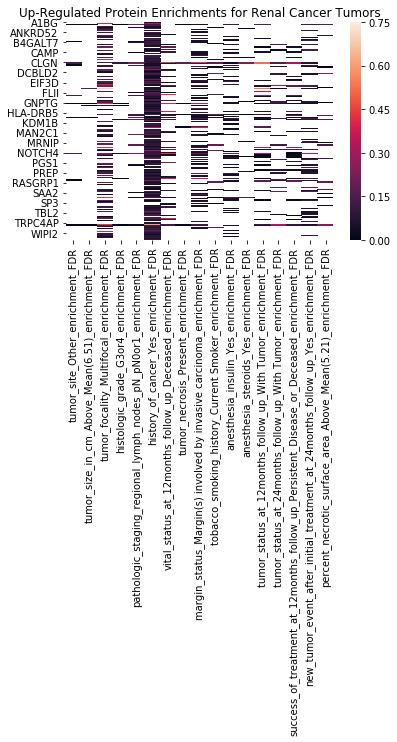

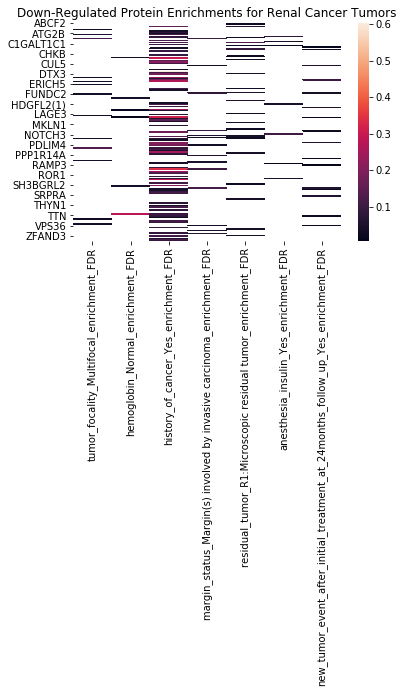

In [43]:
ax1 = plt.axes()
sns.heatmap(results_up, ax = ax1)
ax1.set_title('Up-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

ax2 = plt.axes()
sns.heatmap(results_down, ax = ax2)
ax2.set_title('Down-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [44]:
for col in sig_cols_up:
    print(col.columns[0])
    print(list(col.index))
    print('\n')

tumor_site_Other_P_values
['ACBD3', 'AVL9', 'COG1', 'COG4', 'GOLPH3L', 'IGF2BP3', 'RAB3GAP1', 'TXNRD1']


tumor_size_in_cm_Above_Mean(6.51)_P_values
['ACBD3', 'GOLPH3L', 'GSDME', 'IGF2BP3', 'TXNRD1']


tumor_focality_Multifocal_P_values
['AGL', 'ATG5', 'CTPS2', 'DCAF7', 'HDAC4', 'KRT8', 'MCF2L', 'NEK9', 'PLEC', 'PPIA', 'RCBTB2', 'SDK1', 'SNTB1', 'TLN2', 'UPF3A', 'ZC2HC1A']


histologic_grade_G3or4_P_values
['ACBD3', 'GOLPH3L', 'GSDME', 'IRS2', 'NPEPPS', 'PYCR2', 'TXNRD1']


pathologic_staging_regional_lymph_nodes_pN_pN0or1_P_values
['AEBP1', 'AZU1', 'CAMP', 'FLNC', 'PKP3', 'S100P', 'SHBG', 'TXNRD1']


history_of_cancer_Yes_P_values
['ADD2', 'AP4E1', 'AP5B1', 'ARG1', 'ATP7A', 'BCCIP', 'BPGM', 'C4B', 'C9orf40', 'CA1(1)', 'CA3', 'CAAP1', 'CACHD1', 'CEP128', 'CLNS1A', 'CNDP1', 'CNOT8', 'COMMD8', 'CYTH2', 'DAZAP2(1)', 'DENND4B', 'DHX40', 'DLC1', 'DNAJC16', 'DOHH', 'DOLK', 'EPB41(1)', 'ERF', 'F13B', 'FBXO7', 'FCN3', 'FGA', 'FGB', 'FGG', 'FLII', 'GEMIN2', 'GID8', 'GNAS', 'GYPC', 'HBA2', 'HBB'

In [45]:
for col in sig_cols_down:
    print(col.columns[0])
    print(list(col.index))
    print('\n')

tumor_focality_Multifocal_P_values
['ANXA6(1)', 'ATP2C1', 'EIF2B2', 'EMC1', 'EXOC1', 'FUNDC2', 'LGALSL', 'NUP210', 'PSMG3', 'UBP1', 'UXT', 'VEZT']


hemoglobin_Normal_P_values
['CNBP', 'GNB1', 'IFT27', 'LMO4', 'SIVA1']


history_of_cancer_Yes_P_values
['ARF3', 'ARL6IP4(2)', 'ATN1', 'CCAR2', 'DEPDC5', 'EIF2B4', 'EIF3M', 'ELOC', 'FEM1B', 'FIP1L1', 'GTF3C2', 'MED6', 'OTUB1', 'POLR2F', 'QTRT1', 'SNRPF', 'SP3', 'THYN1', 'UBE3B']


margin_status_Margin(s) involved by invasive carcinoma_P_values
['DAG1', 'NRIP2', 'PEAR1', 'PTPRG', 'VPS36']


residual_tumor_R1:Microscopic residual tumor_P_values
['ACTA2', 'BASP1', 'C7orf43', 'CLP1', 'COL16A1', 'DTNA', 'FAM89A', 'KIAA1211', 'MEMO1', 'MYPN', 'NPM3', 'NUMBL', 'POMGNT2', 'PPIC', 'SETD2', 'SYNGR3', 'WDR92', 'WIPF3', 'ZCCHC9']


anesthesia_insulin_Yes_P_values
['BCAS3(1)', 'C9orf78', 'GTPBP1', 'HBS1L', 'RAB23', 'RPS2']


new_tumor_event_after_initial_treatment_at_24months_follow_up_Yes_P_values
['CARMIL1', 'CCDC25', 'FNTB', 'LRRC41', 'NBEA', 'PRPF40

In [46]:
for col in sig_cols_up:
    col_name = col.columns[0]
    col_name = "_".join((col_name.split(" ")))
    print(col_name)
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/renal')
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

tumor_site_Other_P_values


2019-08-14 11:44:11,975 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                       Term Overlap   P-value  \
0  KEGG_2019_Human  Selenocompound metabolism    1/17  0.006781   
1  KEGG_2019_Human   Hepatocellular carcinoma   1/168  0.065268   
2  KEGG_2019_Human         Pathways in cancer   1/530  0.193376   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  147.058824   
1               1.0            0                     0   14.880952   
2               1.0            0                     0    4.716981   

   Combined Score   Genes  
0      734.359493  TXNRD1  
1       40.613893  TXNRD1  
2        7.750568  TXNRD1  
tumor_size_in_cm_Above_Mean(6.51)_P_values


2019-08-14 11:44:14,834 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                       Term Overlap   P-value  \
0  KEGG_2019_Human  Selenocompound metabolism    1/17  0.004243   
1  KEGG_2019_Human   Hepatocellular carcinoma   1/168  0.041304   
2  KEGG_2019_Human         Pathways in cancer   1/530  0.125673   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  235.294118   
1               1.0            0                     0   23.809524   
2               1.0            0                     0    7.547170   

   Combined Score   Genes  
0     1285.282536  TXNRD1  
1       75.876009  TXNRD1  
2       15.653391  TXNRD1  
tumor_focality_Multifocal_P_values


2019-08-14 11:44:17,638 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                     Term Overlap  \
0   KEGG_2019_Human            Starch and sucrose metabolism    1/36   
1   KEGG_2019_Human                              Ferroptosis    1/40   
2   KEGG_2019_Human                    Pyrimidine metabolism    1/57   
3   KEGG_2019_Human                                Mitophagy    1/65   
4   KEGG_2019_Human                              Shigellosis    1/65   
5   KEGG_2019_Human    RIG-I-like receptor signaling pathway    1/70   
6   KEGG_2019_Human                mRNA surveillance pathway    1/91   
7   KEGG_2019_Human             Longevity regulating pathway   1/102   
8   KEGG_2019_Human                      Platelet activation   1/124   
9   KEGG_2019_Human                                Autophagy   1/128   
10  KEGG_2019_Human                 Apelin signaling pathway   1/137   
11  KEGG_2019_Human                              Necroptosis   1/162   
12  KEGG_2019_Human                            RNA transport   1

2019-08-14 11:44:20,498 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                       Term Overlap  \
0   KEGG_2019_Human                  Selenocompound metabolism    1/17   
1   KEGG_2019_Human                  Type II diabetes mellitus    1/46   
2   KEGG_2019_Human            Arginine and proline metabolism    1/49   
3   KEGG_2019_Human      Regulation of lipolysis in adipocytes    1/55   
4   KEGG_2019_Human            Adipocytokine signaling pathway    1/69   
5   KEGG_2019_Human               Longevity regulating pathway   1/102   
6   KEGG_2019_Human                         Insulin resistance   1/108   
7   KEGG_2019_Human                     AMPK signaling pathway   1/120   
8   KEGG_2019_Human                                  Autophagy   1/128   
9   KEGG_2019_Human                     FoxO signaling pathway   1/132   
10  KEGG_2019_Human                  Insulin signaling pathway   1/137   
11  KEGG_2019_Human  Non-alcoholic fatty liver disease (NAFLD)   1/149   
12  KEGG_2019_Human                 cG

2019-08-14 11:44:23,314 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                 Term Overlap   P-value  \
0   KEGG_2019_Human            Selenocompound metabolism    1/17  0.006781   
1   KEGG_2019_Human      Staphylococcus aureus infection    1/68  0.026883   
2   KEGG_2019_Human                 Salmonella infection    1/86  0.033892   
3   KEGG_2019_Human                   Salivary secretion    1/90  0.035444   
4   KEGG_2019_Human             Hepatocellular carcinoma   1/168  0.065268   
5   KEGG_2019_Human  NOD-like receptor signaling pathway   1/178  0.069033   
6   KEGG_2019_Human                         Tuberculosis   1/179  0.069408   
7   KEGG_2019_Human                       Focal adhesion   1/199  0.076895   
8   KEGG_2019_Human              Proteoglycans in cancer   1/201  0.077641   
9   KEGG_2019_Human               MAPK signaling pathway   1/295  0.112103   
10  KEGG_2019_Human                   Pathways in cancer   1/530  0.193376   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds R

[85 rows x 10 columns]
vital_status_at_12months_follow_up_Deceased_P_values


2019-08-14 11:44:30,768 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human    Aldosterone-regulated sodium reabsorption    1/37   
1   KEGG_2019_Human  Amino sugar and nucleotide sugar metabolism    1/48   
2   KEGG_2019_Human                       Cholesterol metabolism    1/50   
3   KEGG_2019_Human                        p53 signaling pathway    1/72   
4   KEGG_2019_Human                         Salmonella infection    1/86   
5   KEGG_2019_Human                                     Lysosome   1/123   
6   KEGG_2019_Human                                   Cell cycle   1/124   
7   KEGG_2019_Human                                  Necroptosis   1/162   
8   KEGG_2019_Human                                RNA transport   1/165   
9   KEGG_2019_Human          NOD-like receptor signaling pathway   1/178   
10  KEGG_2019_Human                               Focal adhesion   1/199   
11  KEGG_2019_Human                      Proteoglycans in cancer   1/201   
12  KEGG_201

2019-08-14 11:44:33,566 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human                    Selenocompound metabolism    1/17   
1   KEGG_2019_Human                           Pathways in cancer   2/530   
2   KEGG_2019_Human          Antigen processing and presentation    1/77   
3   KEGG_2019_Human                      IL-17 signaling pathway    1/93   
4   KEGG_2019_Human                              Prostate cancer    1/97   
5   KEGG_2019_Human      Progesterone-mediated oocyte maturation    1/99   
6   KEGG_2019_Human                    Th17 cell differentiation   1/107   
7   KEGG_2019_Human                   Estrogen signaling pathway   1/137   
8   KEGG_2019_Human       Fluid shear stress and atherosclerosis   1/139   
9   KEGG_2019_Human                                  Necroptosis   1/162   
10  KEGG_2019_Human  Protein processing in endoplasmic reticulum   1/165   
11  KEGG_2019_Human                     Hepatocellular carcinoma   1/168   
12  KEGG_201

[82 rows x 10 columns]
tobacco_smoking_history_Current_Smoker_P_values


2019-08-14 11:44:40,763 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                      Term Overlap   P-value  \
0  KEGG_2019_Human  Homologous recombination    1/41  0.014264   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0   69.686411   

   Combined Score  Genes  
0      296.168151  BARD1  
anesthesia_insulin_Yes_P_values


2019-08-14 11:44:43,597 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                               Term  \
0   KEGG_2019_Human        Protein processing in endoplasmic reticulum   
1   KEGG_2019_Human                       Epstein-Barr virus infection   
2   KEGG_2019_Human                                        Shigellosis   
3   KEGG_2019_Human                                          Autophagy   
4   KEGG_2019_Human                    Terpenoid backbone biosynthesis   
5   KEGG_2019_Human                           Renin-angiotensin system   
6   KEGG_2019_Human                          Calcium signaling pathway   
7   KEGG_2019_Human                   Mucin type O-glycan biosynthesis   
8   KEGG_2019_Human                                        Ferroptosis   
9   KEGG_2019_Human                                         Proteasome   
10  KEGG_2019_Human                          Type II diabetes mellitus   
11  KEGG_2019_Human                         Hedgehog signaling pathway   
12  KEGG_2019_Human                   

[81 rows x 10 columns]
anesthesia_steroids_Yes_P_values


2019-08-14 11:44:46,410 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                             Term Overlap  \
0   KEGG_2019_Human           Nicotinate and nicotinamide metabolism    1/30   
1   KEGG_2019_Human                  Fructose and mannose metabolism    1/33   
2   KEGG_2019_Human      Amino sugar and nucleotide sugar metabolism    1/48   
3   KEGG_2019_Human                            p53 signaling pathway    1/72   
4   KEGG_2019_Human                                GABAergic synapse    1/89   
5   KEGG_2019_Human                               Salivary secretion    1/90   
6   KEGG_2019_Human                               Morphine addiction    1/91   
7   KEGG_2019_Human                       Hematopoietic cell lineage    1/97   
8   KEGG_2019_Human                            Circadian entrainment    1/97   
9   KEGG_2019_Human                             Pancreatic secretion    1/98   
10  KEGG_2019_Human                              Cholinergic synapse   1/112   
11  KEGG_2019_Human                     

2019-08-14 11:44:49,226 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human  Protein processing in endoplasmic reticulum   3/165   
1   KEGG_2019_Human             Mucin type O-glycan biosynthesis    1/31   
2   KEGG_2019_Human                    Type II diabetes mellitus    1/46   
3   KEGG_2019_Human              Arginine and proline metabolism    1/49   
4   KEGG_2019_Human        Regulation of lipolysis in adipocytes    1/55   
5   KEGG_2019_Human                  Aminoacyl-tRNA biosynthesis    1/66   
6   KEGG_2019_Human              Adipocytokine signaling pathway    1/69   
7   KEGG_2019_Human          Antigen processing and presentation    1/77   
8   KEGG_2019_Human            Ribosome biogenesis in eukaryotes   1/101   
9   KEGG_2019_Human                 Longevity regulating pathway   1/102   
10  KEGG_2019_Human    Chagas disease (American trypanosomiasis)   1/103   
11  KEGG_2019_Human                           Insulin resistance   1/108   
12  KEGG_201

2019-08-14 11:44:52,047 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []
success_of_treatment_at_12months_follow_up_Persistent_Disease_or_Deceased_P_values


2019-08-14 11:44:54,851 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                         Term Overlap  \
0   KEGG_2019_Human          Antigen processing and presentation    2/77   
1   KEGG_2019_Human  Protein processing in endoplasmic reticulum   2/165   
2   KEGG_2019_Human                 Epstein-Barr virus infection   2/201   
3   KEGG_2019_Human             Mucin type O-glycan biosynthesis    1/31   
4   KEGG_2019_Human                          MicroRNAs in cancer   2/299   
5   KEGG_2019_Human                    Type II diabetes mellitus    1/46   
6   KEGG_2019_Human              Arginine and proline metabolism    1/49   
7   KEGG_2019_Human                       Cholesterol metabolism    1/50   
8   KEGG_2019_Human        Regulation of lipolysis in adipocytes    1/55   
9   KEGG_2019_Human                                  Shigellosis    1/65   
10  KEGG_2019_Human              Adipocytokine signaling pathway    1/69   
11  KEGG_2019_Human                     ECM-receptor interaction    1/82   
12  KEGG_201

42        1.656035       HSP90AB1  
new_tumor_event_after_initial_treatment_at_24months_follow_up_Yes_P_values


2019-08-14 11:44:58,714 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                     Term Overlap   P-value  \
0  KEGG_2019_Human                Selenocompound metabolism    1/17  0.009313   
1  KEGG_2019_Human                 Renin-angiotensin system    1/23  0.012581   
2  KEGG_2019_Human                 Hepatocellular carcinoma   1/168  0.088636   
3  KEGG_2019_Human                Calcium signaling pathway   1/188  0.098698   
4  KEGG_2019_Human  Neuroactive ligand-receptor interaction   1/338  0.171000   
5  KEGG_2019_Human                       Pathways in cancer   1/530  0.255845   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  106.951872   
1               1.0            0                     0   79.051383   
2               1.0            0                     0   10.822511   
3               1.0            0                     0    9.671180   
4               1.0            0                     0    5.379236   
5           

2019-08-14 11:45:01,538 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                 Term Overlap   P-value  \
0  KEGG_2019_Human                       Protein export    1/23  0.008023   
1  KEGG_2019_Human  Complement and coagulation cascades    1/79  0.027328   
2  KEGG_2019_Human                             Lysosome   1/123  0.042270   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0  124.223602   
1               1.0            0                     0   36.166365   
2               1.0            0                     0   23.228804   

   Combined Score  Genes  
0      599.427861  SRP72  
1      130.192765     F5  
2       73.488545  GNPTG  


In [47]:
for col in sig_cols_down:
    col_name = col.columns[0]
    col_name = "_".join((col_name.split(" ")))
    print(col_name)
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/renal')
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

tumor_focality_Multifocal_P_values


2019-08-14 11:45:04,420 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                              Term Overlap   P-value  \
0  KEGG_2019_Human                     RNA transport   2/165  0.004229   
1  KEGG_2019_Human  Herpes simplex virus 1 infection   1/492  0.258422   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0   20.202020   
1               1.0            0                     0    3.387534   

   Combined Score          Genes  
0      110.420227  EIF2B2;NUP210  
1        4.583887         EIF2B2  
hemoglobin_Normal_P_values


2019-08-14 11:45:07,224 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                             Term Overlap  \
0   KEGG_2019_Human                                Phototransduction    1/28   
1   KEGG_2019_Human                            p53 signaling pathway    1/72   
2   KEGG_2019_Human                                GABAergic synapse    1/89   
3   KEGG_2019_Human                               Morphine addiction    1/91   
4   KEGG_2019_Human                            Circadian entrainment    1/97   
5   KEGG_2019_Human                              Cholinergic synapse   1/112   
6   KEGG_2019_Human                             Serotonergic synapse   1/113   
7   KEGG_2019_Human                            Glutamatergic synapse   1/114   
8   KEGG_2019_Human                        Relaxin signaling pathway   1/130   
9   KEGG_2019_Human                             Dopaminergic synapse   1/131   
10  KEGG_2019_Human                         Apelin signaling pathway   1/137   
11  KEGG_2019_Human             Retrogra

2019-08-14 11:45:10,046 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                      Term Overlap  \
0   KEGG_2019_Human            Ubiquitin mediated proteolysis   2/137   
1   KEGG_2019_Human                            RNA polymerase    1/31   
2   KEGG_2019_Human             Cytosolic DNA-sensing pathway    1/63   
3   KEGG_2019_Human                      Renal cell carcinoma    1/69   
4   KEGG_2019_Human                 mRNA surveillance pathway    1/91   
5   KEGG_2019_Human                   HIF-1 signaling pathway   1/100   
6   KEGG_2019_Human                               Spliceosome   1/134   
7   KEGG_2019_Human                    mTOR signaling pathway   1/152   
8   KEGG_2019_Human                             RNA transport   1/165   
9   KEGG_2019_Human                        Huntington disease   1/193   
10  KEGG_2019_Human  Human immunodeficiency virus 1 infection   1/212   
11  KEGG_2019_Human                               Endocytosis   1/244   
12  KEGG_2019_Human          Herpes simplex virus 1

2019-08-14 11:45:12,842 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                               Term Overlap  \
0  KEGG_2019_Human                                  Viral myocarditis    1/59   
1  KEGG_2019_Human  Arrhythmogenic right ventricular cardiomyopath...    1/72   
2  KEGG_2019_Human                           ECM-receptor interaction    1/82   
3  KEGG_2019_Human                  Hypertrophic cardiomyopathy (HCM)    1/85   
4  KEGG_2019_Human                       Dilated cardiomyopathy (DCM)    1/91   
5  KEGG_2019_Human                                        Endocytosis   1/244   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.014665               1.0            0                     0   67.796610   
1  0.017872               1.0            0                     0   55.555556   
2  0.020334               1.0            0                     0   48.780488   
3  0.021072               1.0            0                     0   47.058824   
4  0.022546               1.0   

2019-08-14 11:45:15,645 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                Term Overlap   P-value  \
0  KEGG_2019_Human  Mannose type O-glycan biosynthesis    1/23  0.021635   
1  KEGG_2019_Human             Notch signaling pathway    1/48  0.044648   
2  KEGG_2019_Human                  Lysine degradation    1/59  0.054610   
3  KEGG_2019_Human           mRNA surveillance pathway    1/91  0.083035   
4  KEGG_2019_Human           Relaxin signaling pathway   1/130  0.116584   
5  KEGG_2019_Human  Vascular smooth muscle contraction   1/132  0.118272   
6  KEGG_2019_Human            Apelin signaling pathway   1/137  0.122481   
7  KEGG_2019_Human                         Endocytosis   1/244  0.208108   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0   45.766590   
1               1.0            0                     0   21.929825   
2               1.0            0                     0   17.841213   
3               1.0            0   

2019-08-14 11:45:18,445 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                       Term Overlap   P-value  \
0  KEGG_2019_Human              Legionellosis    1/55  0.016389   
1  KEGG_2019_Human  mRNA surveillance pathway    1/91  0.026994   
2  KEGG_2019_Human                   Ribosome   1/153  0.045036   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0   60.606061   
1               1.0            0                     0   36.630037   
2               1.0            0                     0   21.786492   

   Combined Score  Genes  
0      249.160755  HBS1L  
1      132.312167  HBS1L  
2       67.544337   RPS2  
new_tumor_event_after_initial_treatment_at_24months_follow_up_Yes_P_values


2019-08-14 11:45:21,233 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                Term Overlap   P-value  \
0  KEGG_2019_Human     Terpenoid backbone biosynthesis    1/22  0.010948   
1  KEGG_2019_Human  Vascular smooth muscle contraction   1/132  0.064088   
2  KEGG_2019_Human                         Spliceosome   1/134  0.065030   
3  KEGG_2019_Human                         Endocytosis   1/244  0.115540   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0               1.0            0                     0   90.909091   
1               1.0            0                     0   15.151515   
2               1.0            0                     0   14.925373   
3               1.0            0                     0    8.196721   

   Combined Score    Genes  
0      410.417610     FNTB  
1       41.628846    RAMP3  
2       40.789754  PRPF40B  
3       17.689676    VPS36  


In [48]:
dgidb_requests_up = []

for col in sig_cols_up:
    sig_genes = list(col.index)
    r = bf.dgidb_get_request(sig_genes)
    dgidb_requests_up.append(r)
    print('\n')

This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=ACBD3,AVL9,COG1,COG4,GOLPH3L,IGF2BP3,RAB3GAP1,TXNRD1

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs


This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=ACBD3,GOLPH3L,GSDME,IGF2BP3,TXNRD1

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs


This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=AGL,ATG5,CTPS2,DCAF7,HDAC4,KRT8,MCF2L,NEK9,PLEC,PPIA,RCBTB2,SDK1,SNTB1,TLN2,UPF3A,ZC2HC1A

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs


This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=ACBD3,GOLPH3L,GSDME,IRS2,NPEPPS,PYCR2,TXNRD1

See www.dgidb.org/api or this function's docst

In [49]:
dgidb_requests_down = []

for col in sig_cols_down:
    sig_genes = list(col.index)
    r = bf.dgidb_get_request(sig_genes)
    dgidb_requests_down.append(r)
    print('\n')

This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=ANXA6(1),ATP2C1,EIF2B2,EMC1,EXOC1,FUNDC2,LGALSL,NUP210,PSMG3,UBP1,UXT,VEZT

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs


This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=CNBP,GNB1,IFT27,LMO4,SIVA1

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs


This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=ARF3,ARL6IP4(2),ATN1,CCAR2,DEPDC5,EIF2B4,EIF3M,ELOC,FEM1B,FIP1L1,GTF3C2,MED6,OTUB1,POLR2F,QTRT1,SNRPF,SP3,THYN1,UBE3B

See www.dgidb.org/api or this function's docstring for further explanation and resources on valid parameter inputs


This is the full URL to your GET request:
http://www.dgidb.org/api/v2/interactions.json?genes=DAG1,NRIP2,PEAR1,PTPRG,VPS36

See www.dgidb.org/ap

In [50]:
bf.dgidb_get_request?

In [51]:
#%%timeit
example = dgidb_requests_up[1]
matched = example.json().get('matchedTerms')
new_json = {}
new_list = []
for i in matched:
    print('Gene:', i.get('geneName'))
    if len(i.get('interactions')) == 0:
        print('Drugs: None')
    else:
        for item in i.get('interactions'):
            print('Drug Name:', item.get('drugName'))
            print('Interaction Type:', item.get('interaction_types'))
    print('\n')

Gene: ACBD3
Drugs: None


Gene: GOLPH3L
Drugs: None


Gene: GSDME
Drugs: None


Gene: IGF2BP3
Drugs: None


Gene: TXNRD1
Drug Name: ARSENIC TRIOXIDE
Interaction Type: None
Drug Name: MOTEXAFIN GADOLINIUM
Interaction Type: None
Drug Name: CHEMBL449269
Interaction Type: None
Drug Name: FLAVIN ADENINE DINUCLEOTIDE
Interaction Type: None
Drug Name: SPERMIDINE
Interaction Type: None
Drug Name: FOTEMUSTINE
Interaction Type: None




In [52]:
#%%timeit
print('UP-REGULATED:\n')
for i, request in enumerate(dgidb_requests_up):
    print('Genes and drugs for: ' + sig_cols_up[i].columns[0] +':\n')
    drug_dict_up = bf.dgidb_json_parse(request.json())

UP-REGULATED:

Genes and drugs for: tumor_site_Other_P_values:



KeyError: 'interaction_types'

In [ ]:
#%%timeit
print('DOWN-REGULATED:\n')
for i, request in enumerate(dgidb_requests_down):
    print('Genes and drugs for: ' + sig_cols_down[i].columns[0] +':\n')
    drug_dict_down = bf.dgidb_json_parse(request.json())